# **Time Evolution of the Transverse-Field Ising Model using Trotterization**


The **Transverse-Field Ising Model (TFIM)** is a fundamental quantum many-body system used to study quantum phase transitions, entanglement, and quantum computation. It consists of spins arranged in a 1D chain, where each spin interacts with its nearest neighbor via an **Ising interaction** while simultaneously experiencing a **transverse magnetic field** that induces quantum fluctuations. The competition between these two effects drives rich quantum behavior.

The **Transverse-Field Ising Model (TFIM)** is described by the Hamiltonian:

$$
\mathcal{H} = J \sum_{i} Z_i Z_{i+1} - B \sum_{i} X_i
$$

where:
- $J$ represents the **Ising coupling** between nearest-neighbor qubits,
- $B$ represents the **transverse magnetic field**, inducing spin flips,
- $Z_i$ and $X_i$ are Pauli matrices acting on qubit $i$.

This Hamiltonian consists of two non-commuting terms:

$$
\mathcal{H} = \mathcal{H}_Z + \mathcal{H}_X
$$

where:
- $\mathcal{H}_Z = J \sum_{i} Z_i Z_{i+1}$ represents the **Ising interaction term**.
- $\mathcal{H}_X = -B \sum_{i} X_i$ represents the **transverse field term**.

## **Trotterization of Time Evolution**

The time evolution operator is given by:

$$
U(t) = e^{-i \mathcal{H} t}
$$

For small time steps $\Delta t$, we approximate:

$$
e^{-i (\mathcal{H}_Z + \mathcal{H}_X) \Delta t} \approx e^{-i \mathcal{H}_Z \Delta t} e^{-i \mathcal{H}_X \Delta t} + \mathcal{O}(\Delta t^2)
$$

This is the **first-order Trotter-Suzuki decomposition**, which introduces an error term of order $\mathcal{O}(\Delta t^2)$, but allows for efficient simulation on quantum hardware.

### **Transverse Field Evolution Term $ e^{-i \mathcal{H}_X \Delta t} $**

Since the transverse field term is a sum of Pauli-X operators:

$$
e^{-i \mathcal{H}_X \Delta t} = e^{i B \sum_i X_i \Delta t}
$$

For a single-qubit Pauli operator:

$$
e^{i \theta X} = \cos(\theta) I + i \sin(\theta) X
$$

this results in the matrix:

$$
e^{i B X \Delta t} =
\begin{bmatrix} 
\cos(B \Delta t) & i \sin(B \Delta t) \\ 
i \sin(B \Delta t) & \cos(B \Delta t)
\end{bmatrix}
$$

which matches the **RX gate** with rotation:

$$
RX(-2 B \Delta t) = e^{i B X \Delta t}
$$

Thus, we implement the transverse field term using **RX gates**:

$$
RX(-2 B \Delta t)
$$

on each qubit.

### **Ising Interaction Term $ e^{-i \mathcal{H}_Z \Delta t} $**

The Ising term involves **ZZ interactions**:

$$
e^{-i \mathcal{H}_Z \Delta t} = e^{i J \sum_i Z_i Z_{i+1} \Delta t}
$$

For a single pair of qubits:

$$
e^{i \theta Z_1 Z_2 \Delta t}
$$

this corresponds to the **CNOT-RZ-CNOT** decomposition:

$$
e^{i J Z_i Z_{i+1} \Delta t} = \text{CNOT} \cdot RZ(-2J \Delta t) \cdot \text{CNOT}
$$

### **Final Quantum Circuit Implementation**
To implement one step of **Trotter evolution**, we apply:
1. **RX gates** on each qubit for the transverse field term.
2. **CNOT-RZ-CNOT sequence** for the Ising interaction term.

For $N$ Trotter steps, this sequence is repeated $N$ times.

---

One time step of Trotterization for the Hamiltonian 

$H = J \sum_i Z_i Z_{i+1} -B \sum_i X_i$

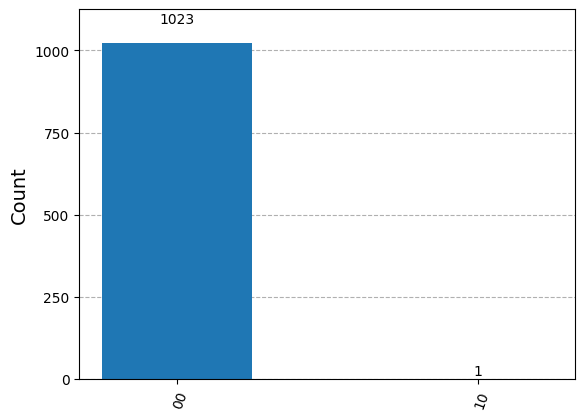

In [1]:
##### Single step of Trotter propagation in transverse-field Ising model #####

import numpy as np

# Import standard Qiskit libraries
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import *

### Physical parameters (atomic units) ###
J = 1.0    # Exchange coupling
B = 0.5    # Transverse magnetic field
dt = 0.01  # Time-discretization unit

### Build a circuit ###

circ = QuantumCircuit(2, 2)  # 2 quantum & 2 classical registers

circ.rx(-2*dt*B, 0)  # Transverse-field propagation of spin 0
circ.rx(-2*dt*B, 1)  # Transverse-field propagation of spin 0
circ.cx(0, 1)        # Exchange-coupling time propagation (1)
circ.rz(-2*dt*J, 1)  #                                    (2)
circ.cx(0, 1)        #                                    (3)
circ.measure(range(2), range(2))  # Measure both spins
circ.draw('mpl')


### Simulate on simulator backend ###

# Use Aer simulator
backend = AerSimulator()
# Transpile the quantum circuit to low-level instructions
from qiskit import transpile
circ_compiled = transpile(circ, backend)
# Execute the circuit on the simulator, repeating 1024 times
job_sim = backend.run(circ_compiled, shots=1024)
# Grab the results from the job
result_sim = job_sim.result()
# Get the result
counts = result_sim.get_counts(circ_compiled)
# Plot histogram
from qiskit.visualization import plot_histogram
plot_histogram(counts)

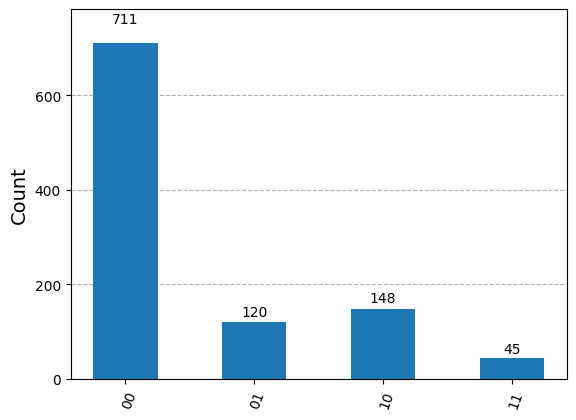

In [6]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

### Physical parameters ###
J = 1.0    # Exchange coupling strength
B = 0.5    # Transverse magnetic field strength
dt = 0.01  # Time step
N = 100     # Number of Trotter steps

### Build a quantum circuit ###
circ = QuantumCircuit(2, 2)  # 2 qubits, 2 classical registers

for _ in range(N):
    # Transverse-field evolution (RX gates)
    circ.rx(-2 * dt * B, 0)
    circ.rx(-2 * dt * B, 1)

    # Ising interaction evolution (CNOT-RZ-CNOT sequence)
    circ.cx(0, 1)
    circ.rz(-2 * dt * J, 1)
    circ.cx(0, 1)

# Measure both qubits
circ.measure(range(2), range(2))

### Simulate the circuit ###
backend = AerSimulator()
circ_compiled = transpile(circ, backend)  # Transpile for execution

# Execute the circuit on the simulator with 1024 shots
job_sim = backend.run(circ_compiled, shots=1024)
result_sim = job_sim.result()

# Get measurement results
counts = result_sim.get_counts(circ_compiled)

# Plot results
plot_histogram(counts)

In [3]:
circ.draw()

┌───────────┐                       ┌───────────┐                       »
q_0: ┤ Rx(-0.01) ├──■─────────────────■──┤ Rx(-0.01) ├──■─────────────────■──»
     ├───────────┤┌─┴─┐┌───────────┐┌─┴─┐├───────────┤┌─┴─┐┌───────────┐┌─┴─┐»
q_1: ┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├»
     └───────────┘└───┘└───────────┘└───┘└───────────┘└───┘└───────────┘└───┘»
c: 2/════════════════════════════════════════════════════════════════════════»
                                                                             »
«     ┌───────────┐                       ┌───────────┐                       »
«q_0: ┤ Rx(-0.01) ├──■─────────────────■──┤ Rx(-0.01) ├──■─────────────────■──»
«     ├───────────┤┌─┴─┐┌───────────┐┌─┴─┐├───────────┤┌─┴─┐┌───────────┐┌─┴─┐»
«q_1: ┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├»
«     └───────────┘└───┘└───────────┘└───┘└───────────┘└───┘└───────────┘└───┘»
«c: 2/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌───────────┐                       ┌───────────┐                       »
«q_0: ┤ Rx(-0.01) ├──■─────────────────■──┤ Rx(-0.01) ├──■─────────────────■──»
«     ├───────────┤┌─┴─┐┌───────────┐┌─┴─┐├───────────┤┌─┴─┐┌───────────┐┌─┴─┐»
«q_1: ┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├»
«     └───────────┘└───┘└───────────┘└───┘└───────────┘└───┘└───────────┘└───┘»
«c: 2/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌───────────┐                       ┌───────────┐                       »
«q_0: ┤ Rx(-0.01) ├──■─────────────────■──┤ Rx(-0.01) ├──■─────────────────■──»
«     ├───────────┤┌─┴─┐┌───────────┐┌─┴─┐├───────────┤┌─┴─┐┌───────────┐┌─┴─┐»
«q_1: ┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├»
«     └───────────┘└───┘└───────────┘└───┘└───────────┘└───┘└───────────┘└───┘»
«c: 2/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌───────────┐                       ┌───────────┐                       »
«q_0: ┤ Rx(-0.01) ├──■─────────────────■──┤ Rx(-0.01) ├──■─────────────────■──»
«     ├───────────┤┌─┴─┐┌───────────┐┌─┴─┐├───────────┤┌─┴─┐┌───────────┐┌─┴─┐»
«q_1: ┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├┤ Rx(-0.01) ├┤ X ├┤ Rz(-0.02) ├┤ X ├»
«     └───────────┘└───┘└───────────┘└───┘└───────────┘└───┘└───────────┘└───┘»
«c: 2/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌─┐   
«q_0: ┤M├───
«     └╥┘┌─┐
«q_1: ─╫─┤M├
«      ║ └╥┘
«c: 2/═╩══╩═
«      0  1

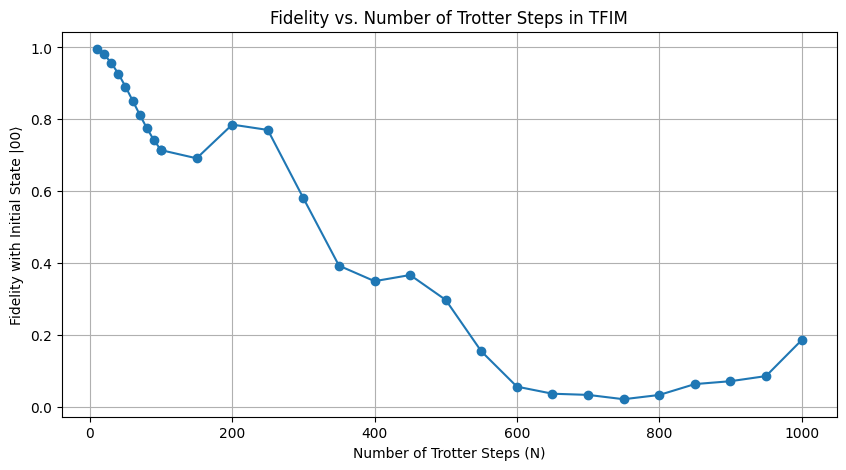

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import state_fidelity, Statevector

### Physical parameters ###
J = 1.0    # Exchange coupling strength
B = 0.5    # Transverse magnetic field strength
dt = 0.01  # Time step

# Define the range of N values to test
N_values = list(range(10, 110, 10)) + list(range(100, 1050, 50))

# Initialize Qiskit simulator
backend = AerSimulator()

# Define the initial state |00>
initial_state = Statevector.from_label('00')

# Store fidelity results
fidelity_results = []

for N in N_values:
    ### Build a quantum circuit ###
    circ = QuantumCircuit(2)

    # Apply Trotter steps
    for _ in range(N):
        # Transverse-field evolution (RX gates)
        circ.rx(-2 * dt * B, 0)
        circ.rx(-2 * dt * B, 1)

        # Ising interaction evolution (CNOT-RZ-CNOT sequence)
        circ.cx(0, 1)
        circ.rz(-2 * dt * J, 1)
        circ.cx(0, 1)

    # Simulate the final quantum state
    circ_compiled = transpile(circ, backend)
    final_state = Statevector(circ_compiled)

    # Compute fidelity with the initial state |00>
    fid = state_fidelity(final_state, initial_state)
    fidelity_results.append(fid)

# Plot fidelity vs. N
plt.figure(figsize=(10, 5))
plt.plot(N_values, fidelity_results, marker='o', linestyle='-')
plt.xlabel('Number of Trotter Steps (N)')
plt.ylabel('Fidelity with Initial State |00⟩')
plt.title('Fidelity vs. Number of Trotter Steps in TFIM')
plt.grid()
plt.show()

### Executing on a Real IBM Quantum Device

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session
from qiskit.quantum_info import state_fidelity, Statevector

### Physical parameters ###
J = 1.0    # Exchange coupling strength
B = 0.5    # Transverse magnetic field strength
dt = 0.01  # Time step
N = 10     # Number of Trotter steps


In [18]:
### Authenticate with IBM Quantum ###
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel='ibm_quantum', instance='<Enter your Instance>', token='<Enter your API Token', overwrite=True)
service = QiskitRuntimeService()  # Ensure you are logged in
backend_name = service.least_busy(n_qubits=127, operational=True)
print("least busy backend: ", backend_name) # Choose a real quantum device
session = Session(service=service, backend=backend_name)

least busy backend:  <IBMBackend('ibm_kyiv')>


/var/folders/s8/49z4mhw56f1gk77hx70jgjsw0000gn/T/ipykernel_51657/1151243668.py:8: DeprecationWarning: The service parameter is deprecated as of qiskit-ibm-runtime 0.26.0 and will be removed no sooner than 3 months after the release date. The service can be extracted from the backend object so it is no longer necessary.
  session = Session(service=service, backend=backend_name)


In [ ]:
### Build the Quantum Circuit ###
circ = QuantumCircuit(2, 2)  # 2 qubits, 2 classical registers

for _ in range(N):
    # Transverse-field evolution (RX gates)
    circ.rx(-2 * dt * B, 0)
    circ.rx(-2 * dt * B, 1)

    # Ising interaction evolution (CNOT-RZ-CNOT sequence)
    circ.cx(0, 1)
    circ.rz(-2 * dt * J, 1)
    circ.cx(0, 1)

# Measure both qubits
circ.measure(range(2), range(2))

### Transpile for the Real Quantum Device ###
circ_compiled = transpile(circ, backend=backend_name, optimization_level=3)

### Execute on a Real Quantum Device using Qiskit Runtime ###
sampler = SamplerV2(mode=session)
job = sampler.run([circ_compiled], shots=1024)

# Wait for results
result = job.result()


In [21]:
# Close the session
session.close()

{'00': 1008, '01': 8, '11': 3, '10': 5}


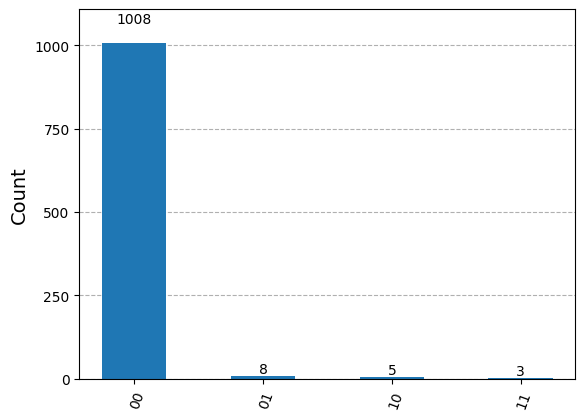

In [25]:
counts = result[0].data.c.get_counts()
print(counts)
plot_histogram(counts)



Measurement Counts from IBM Quantum Device: {'00': 1008, '01': 8, '11': 3, '10': 5}
Fidelity with Initial State |00⟩: 1.0


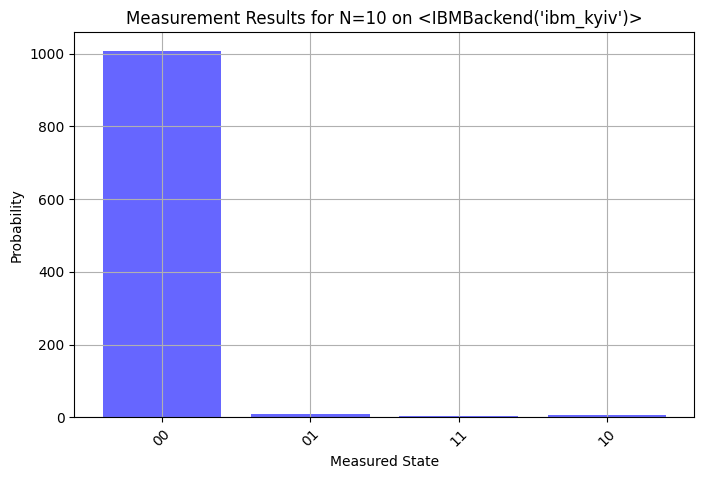

In [26]:
### Compute Fidelity with Initial State ###
initial_state = Statevector.from_label('00')
final_state = Statevector.from_int(int(max(counts, key=counts.get), 2), dims=2**2)
fidelity = state_fidelity(final_state, initial_state)

### Print Results ###
print("Measurement Counts from IBM Quantum Device:", counts)
print("Fidelity with Initial State |00⟩:", fidelity)

### Plot Histogram of Results ###
plt.figure(figsize=(8,5))
plt.bar(counts.keys(), counts.values(), color='blue', alpha=0.6)
plt.xlabel('Measured State')
plt.ylabel('Probability')
plt.title(f'Measurement Results for N={N} on {backend_name}')
plt.xticks(rotation=45)
plt.grid()
plt.show()